In [38]:
# Custom Modules import
from util.data_loader import load_competitions, load_matches
from util.league_table import generate_league_table
from util.elo_calculator import initialize_team_stats, calculate_elo_ratings, loss_from_comparing_tables, elo_grid_search, brier_scores_by_matchweek

from statsbombpy import sb
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Load data
competitions = load_competitions()
matches = load_matches(competition_id=9, season_id=27)

c:\Users\mathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [40]:
# Generate league table
final_table = generate_league_table(matches)
final_table

,team,Matches,Wins,Draws,Losses,Goals_For,Goals_Against,Points,Goal_Difference
0,Bayern Munich,34,28,4,2,80,17,88,63
1,Borussia Dortmund,34,24,6,4,82,34,78,48
2,Bayer Leverkusen,34,18,6,10,56,40,60,16
3,Borussia Mönchengladbach,34,17,4,13,67,50,55,17
4,Schalke 04,34,15,7,12,51,49,52,2
5,FSV Mainz 05,34,14,8,12,46,42,50,4
6,Hertha Berlin,34,14,8,12,42,42,50,0
7,Wolfsburg,34,12,9,13,47,49,45,-2
8,FC Köln,34,10,13,11,38,42,43,-4
9,Hamburger SV,34,11,8,15,40,46,41,-6


# Task 101

## Part 1, Elo Model with arbitrary Hyperparameters k and s

In [41]:
team_stats, elo_history_df = calculate_elo_ratings(matches, K_FACTOR=15, SCALING_FACTOR = 400, HOME_ADVANTAGE=0.00, STARTING_ELO=1000.)
print (loss_from_comparing_tables(final_table,team_stats))

12


## Part 2 with R0 = 100, k = 15 and s = 15

In [42]:
team_stats, elo_history_df = calculate_elo_ratings(matches, K_FACTOR=15, SCALING_FACTOR = 15, HOME_ADVANTAGE=0.00, STARTING_ELO=100.)
print (loss_from_comparing_tables(final_table,team_stats))

82


## Part 3, with optimal K and s 
<br>
Such that the Error of wrong Places between true Table and Elo Rating in minimized

In [43]:
param_grid = {
    'K_FACTOR': [1., 10., 32.], 
    'SCALING_FACTOR': [100., 200., 400.],
    'HOME_ADVANTAGE': [0., 50., 100.],
    'STARTING_ELO': [1000., 1500.]
}


# np.arrange

# Returns best Hyperparameters, best Score and Dataframe of all Combinations with their respective Score
best_params, best_score, all_results = elo_grid_search(
    matches,
    param_grid,
    loss_from_comparing_tables,
    final_table
)



print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'K_FACTOR': 1.0, 'SCALING_FACTOR': 100.0, 'HOME_ADVANTAGE': 0.0, 'STARTING_ELO': 1000.0}
Best Score: 6


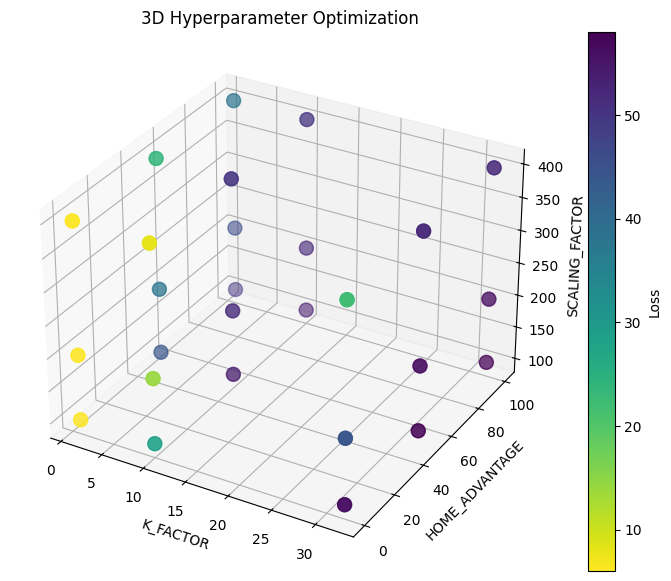

In [44]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter points
scatter = ax.scatter(
    all_results["K_FACTOR"],
    all_results["HOME_ADVANTAGE"],
    all_results["SCALING_FACTOR"],
    c=all_results["loss"],
    cmap="viridis_r",
    s=100,
)

ax.set_xlabel("K_FACTOR")
ax.set_ylabel("HOME_ADVANTAGE")
ax.set_zlabel("SCALING_FACTOR")
plt.colorbar(scatter, label="Loss")
plt.title("3D Hyperparameter Optimization")
plt.show()

## Part 4, most/least Surpising Win/Lose

In [45]:
# Get the most surpising wins/losses 
max_difference = elo_history_df['elo_diff'].abs().max()
rows_with_max_difference = elo_history_df[elo_history_df['elo_diff'].abs() == max_difference]
most_surprising_matches = matches[matches['match_id'].isin(rows_with_max_difference['match_id'].unique())]
most_surprising_matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_week,competition_stage,stadium,referee,home_managers,away_managers
115,3890460,2016-02-27,16:30:00.000,Germany - 1. Bundesliga,2015/2016,VfB Stuttgart,Hannover 96,1,2,23,Regular Season,Mercedes-Benz-Arena,Sascha Stegemann,Jürgen Kramny,Thomas Schaaf


In [46]:
# Get the least surpising wins/losses 
elo_history_without_draws = elo_history_df[elo_history_df['result'] != 'draw']
min_difference = elo_history_without_draws['elo_diff'].abs().min()
rows_with_min_difference = elo_history_without_draws[elo_history_without_draws['elo_diff'].abs() == min_difference]
least_surprising_matches = matches[matches['match_id'].isin(rows_with_min_difference['match_id'].unique())]
least_surprising_matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_week,competition_stage,stadium,referee,home_managers,away_managers
236,3890332,2015-10-17,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Werder Bremen,Bayern Munich,0,1,9,Regular Season,Wohninvest Weserstadion,Christian Dingert,Viktor Skripnik,Josep Guardiola i Sala


# No Part, just Plot of ELO Grid

In [47]:
team_stats, elo_history_df = calculate_elo_ratings(matches, K_FACTOR=1., SCALING_FACTOR = 100., HOME_ADVANTAGE=0.00, STARTING_ELO=1000.)
print (loss_from_comparing_tables(final_table,team_stats))

6


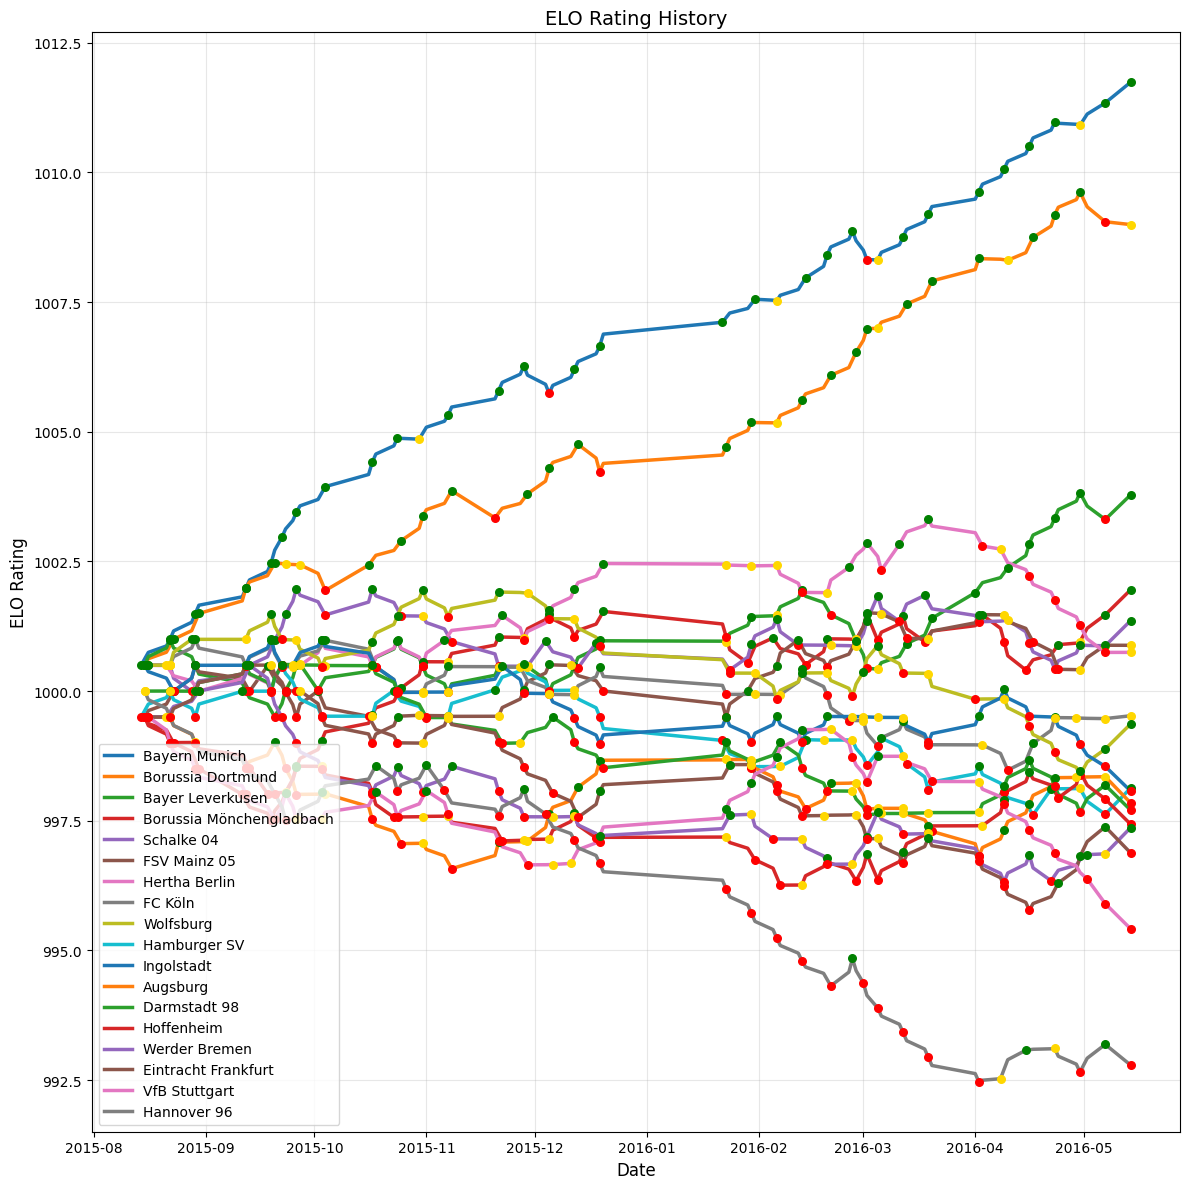

In [48]:
selected_teams = team_stats['team'].tolist()
team_history = elo_history_df

elo_pivot = team_history.pivot(index='date', columns='team', values='elo')
elo_pivot = elo_pivot.sort_index().interpolate()

plt.figure(figsize=(12, 12))

result_colors = {'win': 'green', 'loss': 'red', 'draw': 'gold'}

for team in selected_teams:
    plt.plot(elo_pivot.index, elo_pivot[team], label=team, linewidth=2.5)

    team_points = team_history[team_history['team'] == team]
    for _, row in team_points.iterrows():
        plt.scatter(row['plot_date'], row['elo'], color=result_colors[row['result']], s=30, zorder=5)


plt.title('ELO Rating History', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('ELO Rating', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

   match_week  brier_score
0           1     0.916938
1           2     0.651610
2           3     0.854186
3           4     0.747070
4           5     0.707385


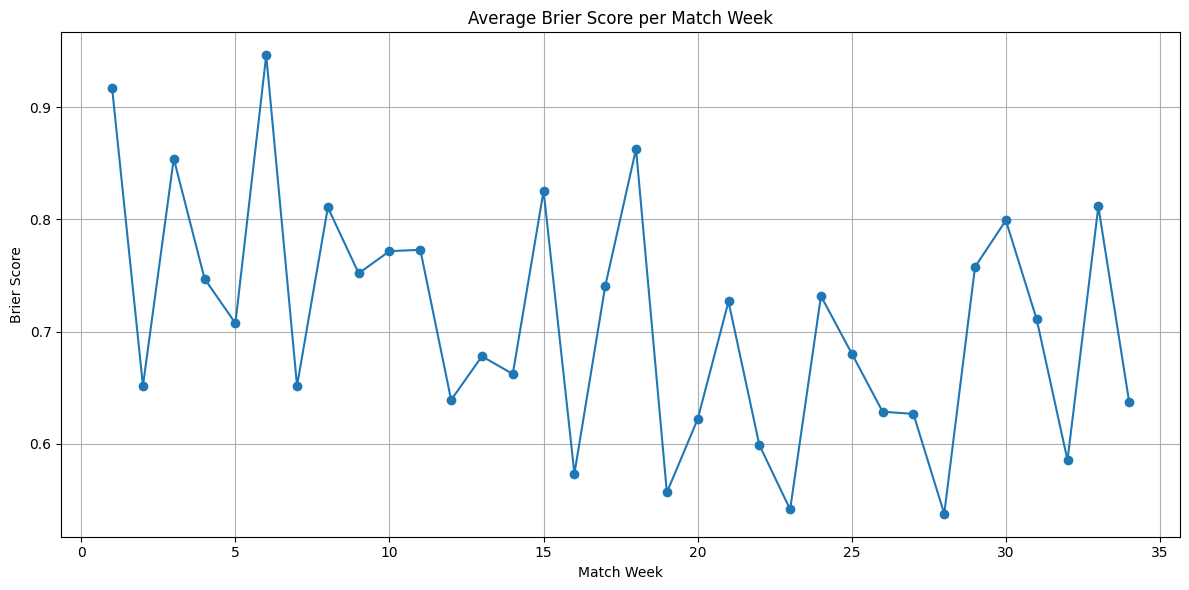

In [49]:
weekly_brier = brier_scores_by_matchweek(matches)
print(weekly_brier.head())


plt.figure(figsize=(12,6))
plt.plot(weekly_brier['match_week'], weekly_brier['brier_score'], marker='o')
plt.title('Average Brier Score per Match Week')
plt.xlabel('Match Week')
plt.ylabel('Brier Score')
plt.grid(True)
plt.tight_layout()
plt.show()
